In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')


In [3]:
df = pd.read_csv('../data/raw/data.csv')

df.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [4]:
print("Rows:", df.shape[0], "Columns:", df.shape[1])

df.dtypes


Rows: 95662 Columns: 16


TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
CurrencyCode             object
CountryCode               int64
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CountryCode,95662.0,256.000000,0.000000,256.0,256.0,256.0,256.0,256.0
Amount,95662.0,6717.846433,123306.797164,-1000000.0,-50.0,1000.0,2800.0,9880000.0
Value,95662.0,9900.583941,123122.087776,2.0,275.0,1000.0,5000.0,9880000.0
PricingStrategy,95662.0,2.255974,0.732924,0.0,2.0,2.0,2.0,4.0
FraudResult,95662.0,0.002018,0.044872,0.0,0.0,0.0,0.0,1.0


In [6]:
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

Series([], dtype: int64)

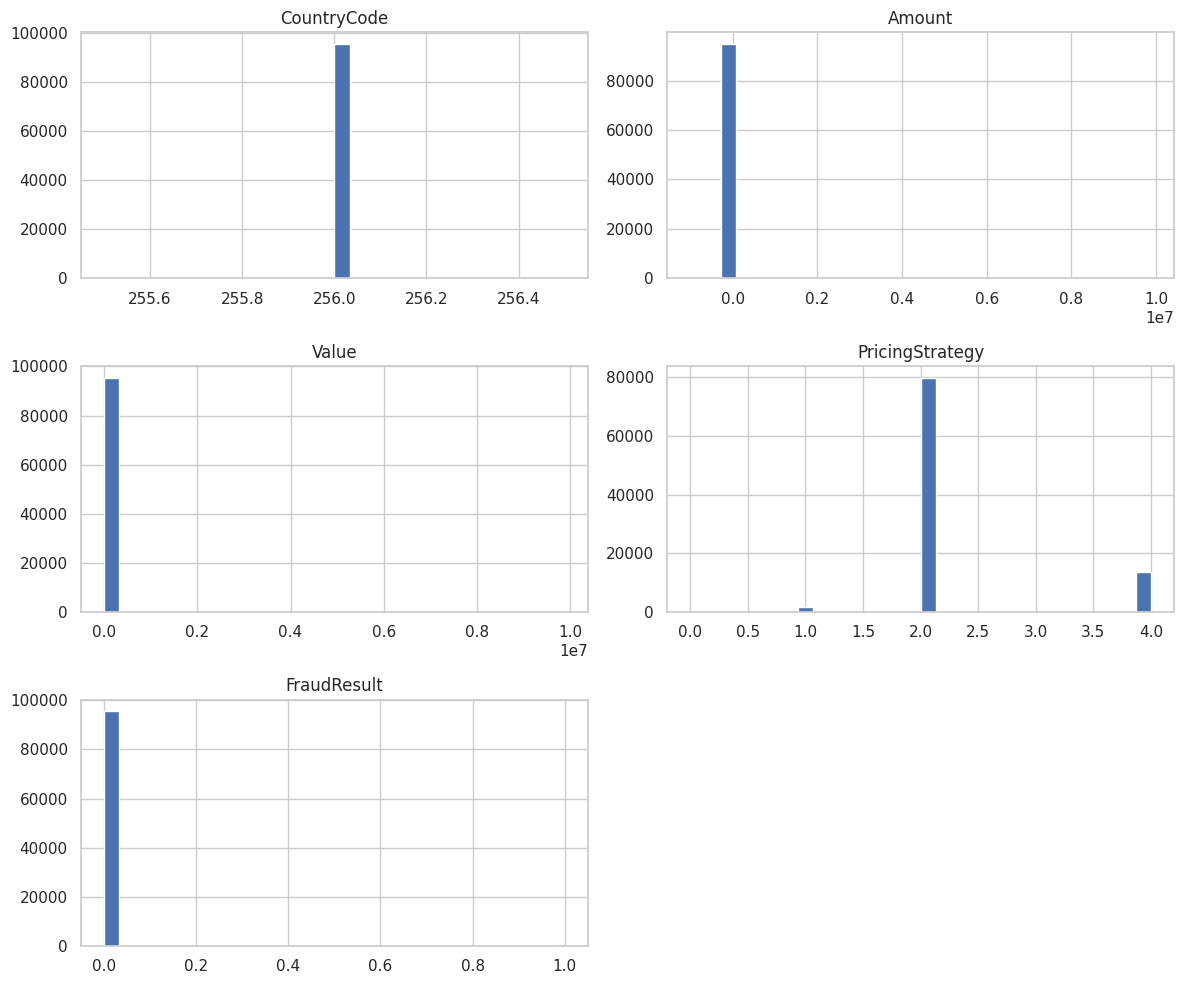

In [7]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns

df[numeric_cols].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()


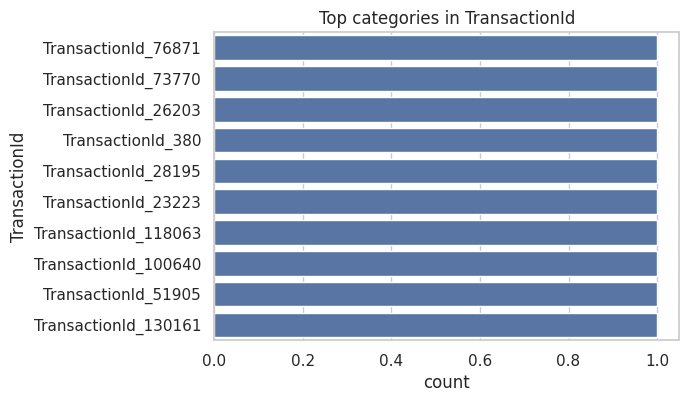

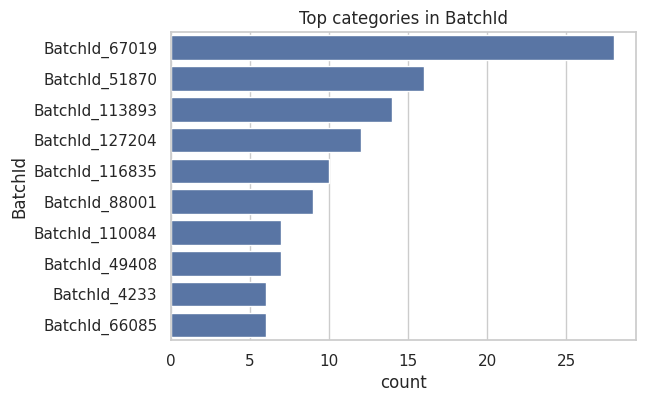

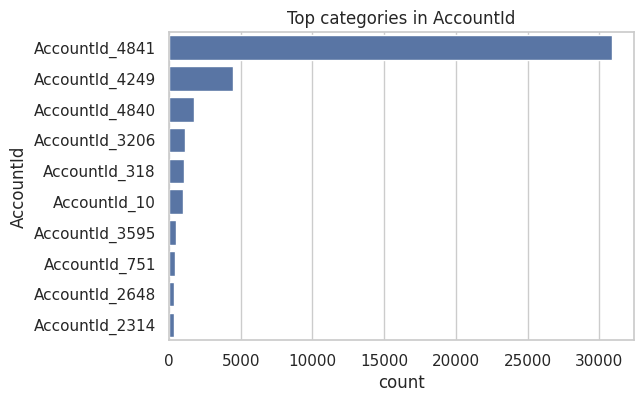

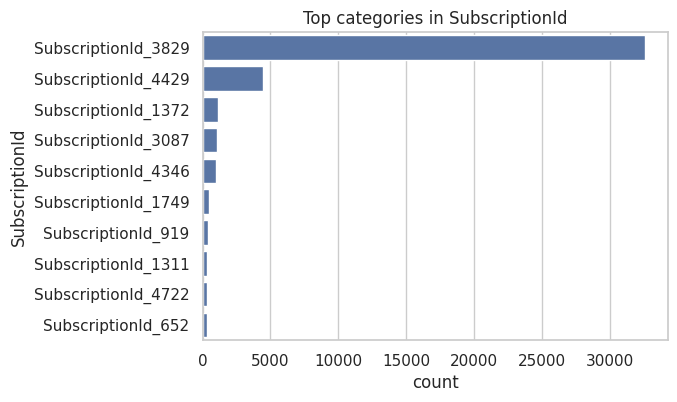

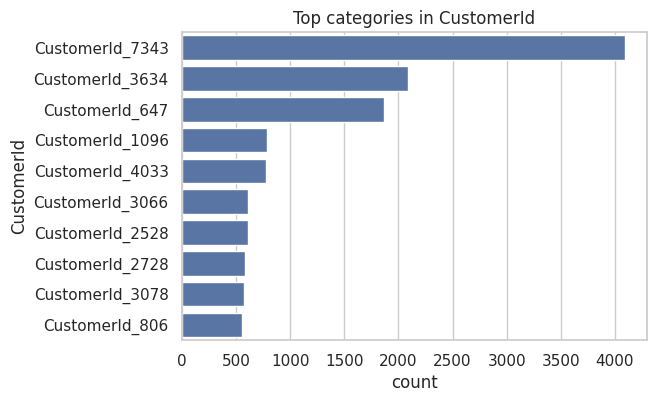

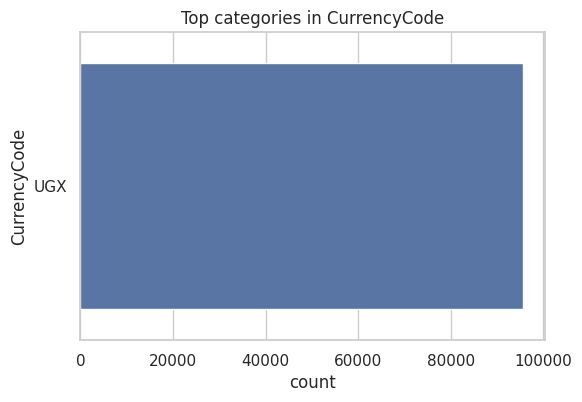

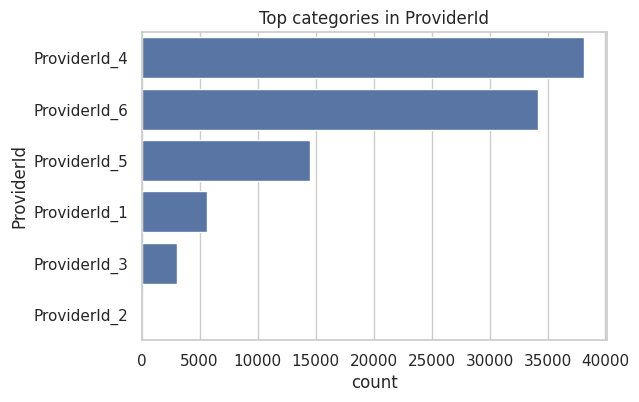

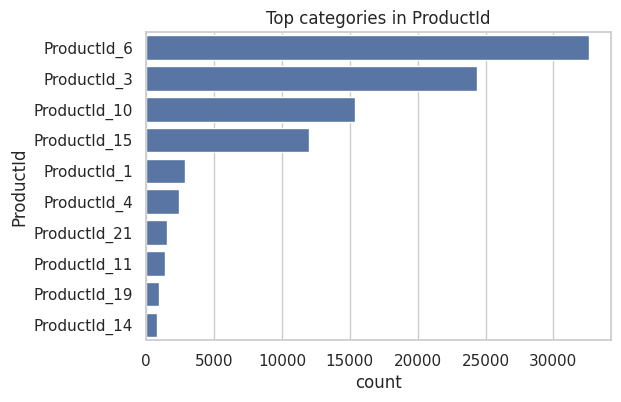

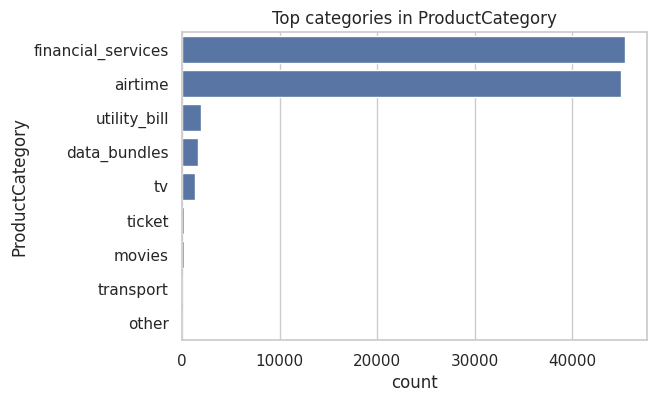

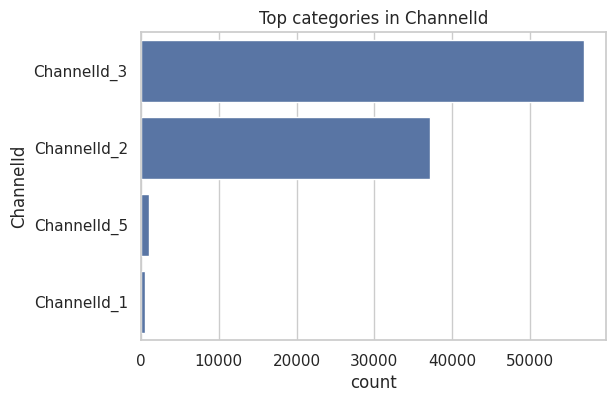

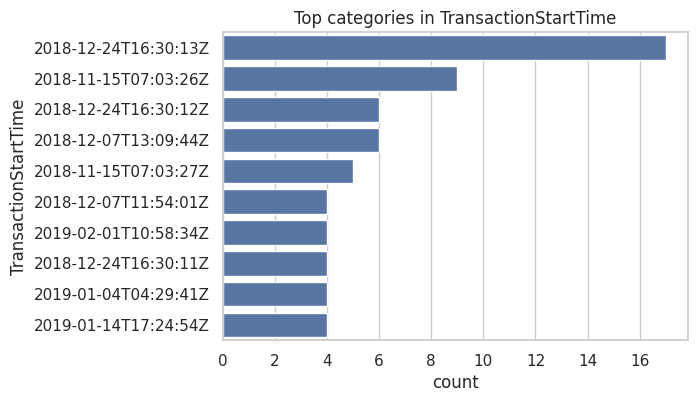

In [8]:
cat_cols = df.select_dtypes(include=['object','category']).columns

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10])
    plt.title(f"Top categories in {col}")
    plt.show()


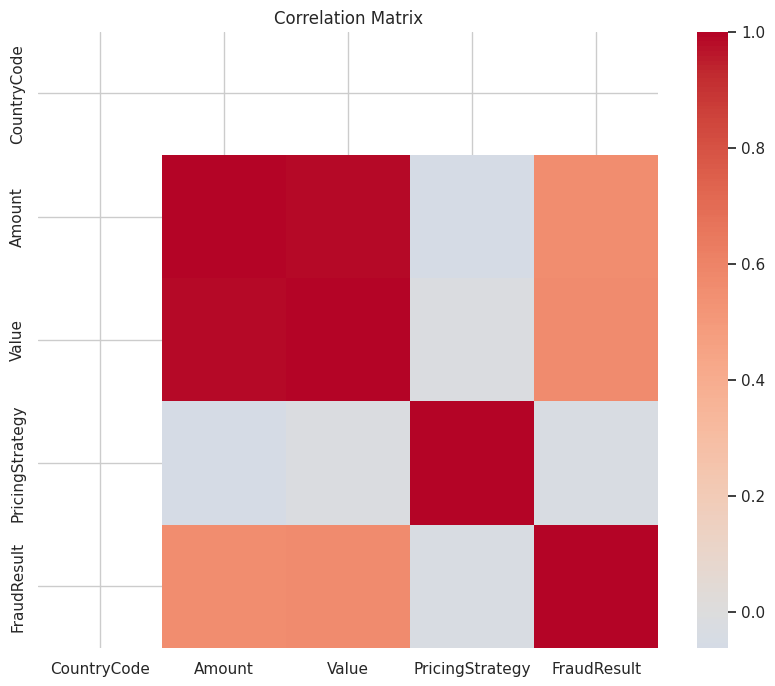

In [9]:
# Compute correlation matrix for numeric features
corr = df[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


## Top 5 Insights

1. **No missing values detected**  
   All 16 columns have complete data—no nulls to impute or drop.

2. **Transaction amounts are highly right‑skewed**  
   • Median = 1 000, mean ≈ 6 718, but max = 9 880 000.  
   • A huge spike of small transactions (< 1 000) and a long tail of extreme outliers.

3. **Amount and Value are essentially the same**  
   Correlation coefficient ≈ 1.0, so one of these redundant features can be dropped.

4. **ChannelId is heavily imbalanced**  
   • ChannelId_3 ≈ 55 000 transactions, ChannelId_2 ≈ 38 000, all other channels combined ≪ 1 000.  
   • Likely need to group or re‑encode rare channels.

5. **Extreme class imbalance in FraudResult**  
   • 0 (non‑fraud) ≈ 99.8% of records, 1 (fraud) ≪ 1%.  
   • Will require special treatment (e.g., stratified sampling, anomaly detection).  


In [10]:
# 1. Convert TransactionStartTime to datetime and extract snapshot date
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
snapshot_date = df['TransactionStartTime'].max() + pd.Timedelta(days=1)

# 2. Group by CustomerId to compute RFM
rfm = df.groupby('CustomerId').agg({
    'TransactionStartTime': lambda x: (snapshot_date - x.max()).days,
    'TransactionId': 'count',
    'Value': 'sum'
}).rename(columns={
    'TransactionStartTime': 'Recency',
    'TransactionId': 'Frequency',
    'Value': 'Monetary'
})

rfm.head()


,Recency,Frequency,Monetary
CustomerId,,,
CustomerId_1,84,1,10000
CustomerId_10,84,1,10000
CustomerId_1001,90,5,30400
CustomerId_1002,26,11,4775
CustomerId_1003,12,6,32000


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = pd.DataFrame(
    scaler.fit_transform(rfm),
    index=rfm.index,
    columns=rfm.columns
)
rfm_scaled.head()


,Recency,Frequency,Monetary
CustomerId,,,
CustomerId_1,1.937605,-0.253459,-0.089524
CustomerId_10,1.937605,-0.253459,-0.089524
CustomerId_1001,2.158882,-0.212186,-0.082011
CustomerId_1002,-0.201408,-0.150278,-0.091448
CustomerId_1003,-0.717722,-0.201868,-0.081422


In [12]:
from sklearn.cluster import KMeans

# 3 clusters, reproducible with random_state
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# View cluster counts
rfm['Cluster'].value_counts().sort_index()


Cluster
0    1435
1       1
2    2306
Name: count, dtype: int64

In [13]:
cluster_profiles = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()
print(cluster_profiles)

# Identify cluster with max Recency & min Frequency
high_risk_cluster = cluster_profiles.sort_values(
    by=['Recency','Frequency','Monetary'],
    ascending=[False,True,True]
).index[0]
high_risk_cluster


           Recency    Frequency      Monetary
Cluster                                      
0        61.715679     7.689199  8.925166e+04
1        29.000000  4091.000000  1.049000e+08
2        12.635299    34.924978  3.096850e+05


np.int32(0)

In [14]:
rfm['is_high_risk'] = (rfm['Cluster'] == high_risk_cluster).astype(int)

# Merge back to main df on CustomerId
df = df.merge(rfm['is_high_risk'], how='left', on='CustomerId')
df['is_high_risk'].value_counts()


is_high_risk
0    84628
1    11034
Name: count, dtype: int64

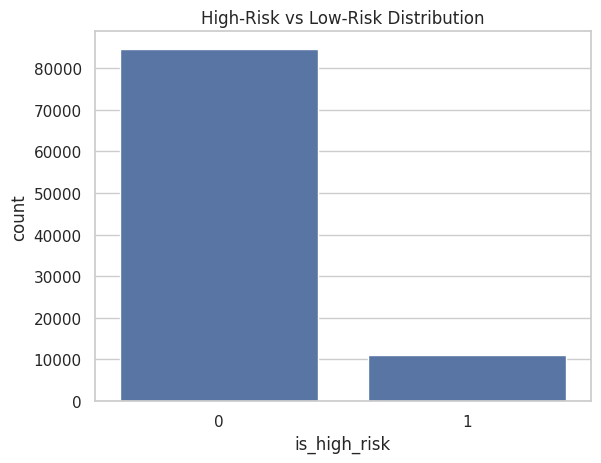

In [15]:
sns.countplot(x='is_high_risk', data=df)
plt.title("High-Risk vs Low-Risk Distribution")
plt.show()
